In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Read mobility forecast data

In [2]:
# Read Forecast for optimistic senario  
df = pd.read_csv ('Data/mobility_forecast_optimistic.csv')       #    ('Data/mobility_forecast_normal.csv')


# Creat year column
df['year']=df.date.astype(str).str[:4]


df.head()

,countyfips,date,mobility,yoy_change,year,month,yearmonth,day,Date
0,11001,2020-02-24 00:00:00,-221.5,NaN,2020,2.0,2020-02,24.0,2020-02-24
1,24009,2020-02-24 00:00:00,-119.5,NaN,2020,2.0,2020-02,24.0,2020-02-24
2,24017,2020-02-24 00:00:00,214.0,NaN,2020,2.0,2020-02,24.0,2020-02-24
3,24021,2020-02-24 00:00:00,143.0,NaN,2020,2.0,2020-02,24.0,2020-02-24
4,24031,2020-02-24 00:00:00,-21.5,NaN,2020,2.0,2020-02,24.0,2020-02-24


Read US county shape file.

In [3]:
county = gpd.read_file("Shape/US_County_Boundaries/US_County_Boundaries.shp")
county.CTFIPS = county.CTFIPS.astype('int')
county.head()

,STFIPS,CTFIPS,STATE,COUNTY,VERSION,Shape_Leng,Shape_Area,geometry
0,02,2016,Alaska,Aleutians West,05,62.576763,1.540013,"MULTIPOLYGON (((-170.34620 57.21312, -170.3328..."
1,02,2290,Alaska,Yukon-Koyukuk,05,63.135667,74.225260,"POLYGON ((-147.99746 64.34170, -148.04161 64.3..."
2,02,2185,Alaska,North Slope,05,130.327563,52.678634,"MULTIPOLYGON (((-149.74913 70.49325, -149.7479..."
3,02,2188,Alaska,Northwest Arctic,05,88.348799,19.328173,"MULTIPOLYGON (((-162.52343 66.04237, -162.5296..."
4,02,2240,Alaska,Southeast Fairbanks,05,21.362151,11.848211,"POLYGON ((-146.48418 63.17392, -146.48920 63.2..."


Merge county shape file to geo data to drop coounties outside of Wasington DC Metro Area.

Read geo data 

In [4]:
# Read Geo Data 
df_g = pd.read_csv('Data/df_geo.csv')
# Include only Washington DC metro area 
cz = df_g[['countyname', 'countyfips', 'stateabbrev']][df_g.czname=='Washington DC']
# Adjust columns names and data type 
cz.rename(columns={'countyfips':'CTFIPS'}, inplace=True)
cz.CTFIPS = cz.CTFIPS.astype('int')

Merge county shape file to geo data and drop coounties outside of Wasington DC Metro Area. 

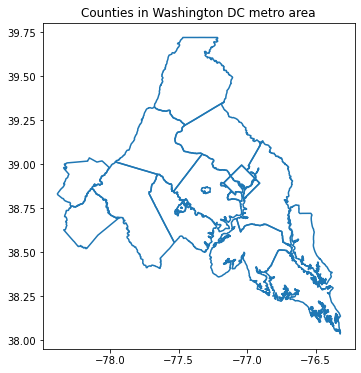

In [5]:
map_county = county.merge(cz, on = 'CTFIPS', how='inner')
map_county.drop_duplicates(inplace=True)
map_county.boundary.plot(figsize=(6,6))
plt.title('Counties in Washington DC metro area');

Merge county shape file and forecasted mobility data, df (business as usual forecast) and dfo (optimistic forecast forcast).

In [6]:
df_map = map_county.merge(df, left_on='CTFIPS', right_on='countyfips', how ='outer')


# Create geo plot by monthly average data 

In [7]:

df_month= df_map.groupby(['countyfips', 'yearmonth']).mean()

df_month.reset_index(inplace=True)


In [8]:
# Merge with county map shape file 
df_month = map_county.merge(df_month, left_on='CTFIPS', right_on='countyfips', how ='inner')
df_month.head()

,STFIPS,CTFIPS_x,STATE,COUNTY,VERSION,Shape_Leng_x,Shape_Area_x,geometry,countyname,stateabbrev,countyfips,yearmonth,CTFIPS_y,Shape_Leng_y,Shape_Area_y,mobility,yoy_change,month,day
0,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2020-02,24021,2.126473,0.180919,167.000000,NaN,2.0,26.5
1,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2020-03,24021,2.126473,0.180919,30.274194,NaN,3.0,16.0
2,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2020-04,24021,2.126473,0.180919,-311.066667,NaN,4.0,15.5
3,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2020-05,24021,2.126473,0.180919,-229.596774,NaN,5.0,16.0
4,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2020-06,24021,2.126473,0.180919,-282.400000,NaN,6.0,15.5


Next, I plot mobility changes for (2022Dec, 2021Dec, 2020Dec, 2020Jan). 2022Dec is model forecast under BAU senario. 

In [9]:
dfm22 = df_month[df_month.yearmonth=='2022-12']
dfm21 = df_month[df_month.yearmonth=='2021-12']
dfm20 = df_month[df_month.yearmonth=='2020-12']
dfm20feb = df_month[df_month.yearmonth=='2020-02']


In [10]:
vmin=df_month.mobility.min() 
vmax=df_month.mobility.max()

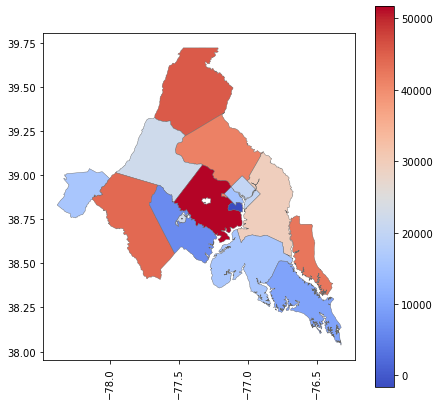

In [11]:
# 2022 (forecast)
fig, ax = plt.subplots(1, figsize=(7, 7))
plt.xticks(rotation=90)
dfm22.plot(column='mobility', cmap="coolwarm", linewidth=0.4, ax=ax, edgecolor=".4", missing_kwds={'color': 'lightgrey'})


bar_info = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
bar_info._A = []
cbar = fig.colorbar(bar_info)

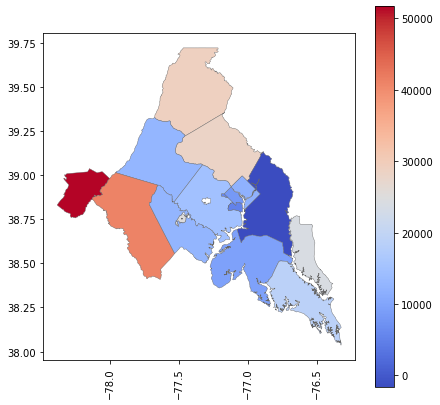

In [12]:
# 2021
fig, ax = plt.subplots(1, figsize=(7, 7))
plt.xticks(rotation=90)
dfm21.plot(column='mobility', cmap="coolwarm", linewidth=0.4, ax=ax, edgecolor=".4", missing_kwds={'color': 'lightgrey'})


bar_info = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
bar_info._A = []
cbar = fig.colorbar(bar_info)

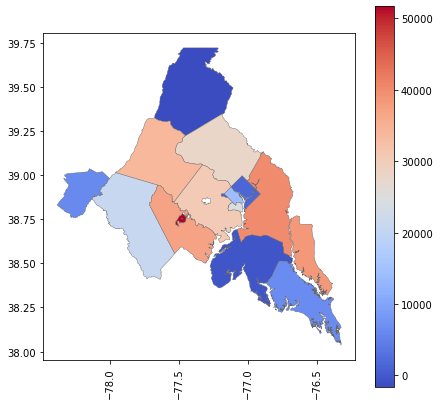

In [13]:
# 2020 
fig, ax = plt.subplots(1, figsize=(7, 7))
plt.xticks(rotation=90)
dfm20.plot(column='mobility', cmap="coolwarm", linewidth=0.4, ax=ax, edgecolor=".4", missing_kwds={'color': 'lightgrey'})


bar_info = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
bar_info._A = []
cbar = fig.colorbar(bar_info)

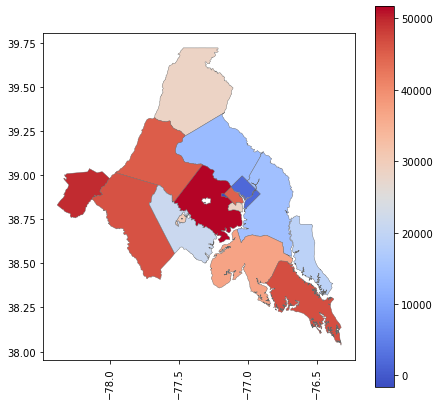

In [14]:
# 2020 Feb (observed) (pre-covid?)
fig, ax = plt.subplots(1, figsize=(7, 7))
plt.xticks(rotation=90)
dfm20feb.plot(column='mobility', cmap="coolwarm", linewidth=0.4, ax=ax, edgecolor=".4", missing_kwds={'color': 'lightgrey'})


bar_info = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=vmin, vmax=vmax))
bar_info._A = []
cbar = fig.colorbar(bar_info)

## Top 5 counties in terms of rising commercial areas vsiters/customers in 2022

In [15]:
dfm22.drop_duplicates(inplace=True)
dfm22.sort_values('mobility', ascending=False).head(5)

,STFIPS,CTFIPS_x,STATE,COUNTY,VERSION,Shape_Leng_x,Shape_Area_x,geometry,countyname,stateabbrev,countyfips,yearmonth,CTFIPS_y,Shape_Leng_y,Shape_Area_y,mobility,yoy_change,month,day
330,51,51059,Virginia,Fairfax,05,2.404727,0.106809,"MULTIPOLYGON (((-77.15000 38.87621, -77.14838 ...",Fairfax,VA,51059.0,2022-12,51059,2.404727,0.106809,126.832303,-2.617673,12.0,16.0
34,24,24021,Maryland,Frederick,05,2.126473,0.180919,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick,MD,24021.0,2022-12,24021,2.126473,0.180919,53.133430,-1.641987,12.0,16.0
219,51,51061,Virginia,Fauquier,05,2.329198,0.174805,"POLYGON ((-77.81144 38.52495, -77.81163 38.525...",Fauquier,VA,51061.0,2022-12,51061,2.329198,0.174805,34.072036,-1.008668,12.0,16.0
515,24,24009,Maryland,Calvert,05,2.760595,0.057742,"MULTIPOLYGON (((-76.47151 38.37185, -76.47142 ...",Calvert,MD,24009.0,2022-12,24009,2.760595,0.057742,15.623589,-0.963401,12.0,16.0
71,24,24031,Maryland,Montgomery,05,1.849972,0.136831,"POLYGON ((-77.11940 38.93491, -77.12290 38.938...",Montgomery,MD,24031.0,2022-12,24031,1.849972,0.136831,1.349690,-0.793028,12.0,16.0


In [16]:
top5 = dfm22.sort_values('mobility', ascending=False).head(5)

In [17]:
top5[['STATE', 'COUNTY', 'mobility', 'geometry','countyname']]

,STATE,COUNTY,mobility,geometry,countyname
330,Virginia,Fairfax,126.832303,"MULTIPOLYGON (((-77.15000 38.87621, -77.14838 ...",Fairfax
34,Maryland,Frederick,53.133430,"POLYGON ((-77.55333 39.62438, -77.55259 39.624...",Frederick
219,Virginia,Fauquier,34.072036,"POLYGON ((-77.81144 38.52495, -77.81163 38.525...",Fauquier
515,Maryland,Calvert,15.623589,"MULTIPOLYGON (((-76.47151 38.37185, -76.47142 ...",Calvert
71,Maryland,Montgomery,1.349690,"POLYGON ((-77.11940 38.93491, -77.12290 38.938...",Montgomery


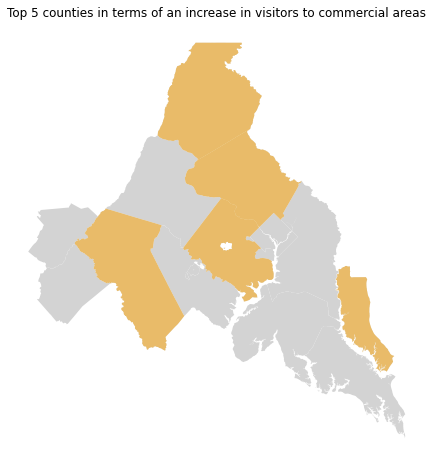

In [22]:
#map_cz = usa.merge(cz, on='zipcode', how='inner')
#map_cz.boundary.plot(figsize=(8, 8));

fig, ax = plt.subplots(figsize = (8,8))
map_county.to_crs(epsg=4326).plot(ax=ax, color='lightgray')
top5.plot(ax=ax, color='orange', alpha=0.5)
ax.set_title('Top 5 counties in terms of an increase in visitors to commercial areas')
ax.axis("off");

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16752 entries, 0 to 16751
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   countyfips  16752 non-null  int64  
 1   date        16752 non-null  object 
 2   mobility    16712 non-null  float64
 3   yoy_change  10992 non-null  float64
 4   year        16752 non-null  object 
 5   month       16736 non-null  float64
 6   yearmonth   16752 non-null  object 
 7   day         16736 non-null  float64
 8   Date        16752 non-null  object 
dtypes: float64(4), int64(1), object(4)
memory usage: 1.2+ MB


In [20]:
map_county.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 17 entries, 0 to 313
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   STFIPS       17 non-null     object  
 1   CTFIPS       17 non-null     int64   
 2   STATE        17 non-null     object  
 3   COUNTY       17 non-null     object  
 4   VERSION      17 non-null     object  
 5   Shape_Leng   17 non-null     float64 
 6   Shape_Area   17 non-null     float64 
 7   geometry     17 non-null     geometry
 8   countyname   17 non-null     object  
 9   stateabbrev  17 non-null     object  
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.5+ KB
